<a href="https://colab.research.google.com/github/chauhansrc/Gender-Classification-CNN/blob/main/Gender_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing and Importing Libraries

In [4]:
!pip install opendatasets --quiet

In [6]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from keras.preprocessing.image import ImageDataGenerator
import opendatasets as od
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Installing and Loading Dataset

In [7]:
od.download("https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shadeofshadow
Your Kaggle Key: ··········


100%|██████████| 269M/269M [00:02<00:00, 140MB/s]


In [8]:
os.listdir("gender-classification-dataset")

['Training', 'Validation']

In [12]:
train_dir = 'gender-classification-dataset/Training'
val_dir = 'gender-classification-dataset/Validation'

In [13]:
train_dir_male = train_dir + '/male'
train_dir_female = train_dir + '/female'

val_dir_male  = val_dir + '/male'
val_dir_female  = val_dir + '/female'

print('number of male training images - ',len(os.listdir(train_dir_male)))
print('number of female training images - ',len(os.listdir(train_dir_female)))
print('----------------------------------------------------------------------')
print('number of male validation  images - ',len(os.listdir(val_dir_male)))
print('number of female validation  images - ',len(os.listdir(val_dir_female)))

number of male training images -  23766
number of female training images -  23243
----------------------------------------------------------------------
number of male validation  images -  5808
number of female validation  images -  5841


In [14]:
classes = os.listdir(train_dir)
print(classes)

['female', 'male']


In [15]:
train_datagen = ImageDataGenerator( # Data Augumentation for test data
rescale=1./255,
rotation_range=30,
shear_range=0.3,
zoom_range=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_gen=train_datagen.flow_from_directory(train_dir,
                                            target_size=(250,250),
                                            batch_size=48,
                                            class_mode='binary')

Found 47009 images belonging to 2 classes.


In [17]:
valid_gen=test_datagen.flow_from_directory(val_dir,
                                           target_size=(250,250),
                                           batch_size=48,
                                           class_mode='binary')

Found 11649 images belonging to 2 classes.


In [18]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([64,64]),
        #transforms.RandomCrop(64, padding=50, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
])

valid_tfms = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor(), transforms.Normalize(*stats)])
train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds = ImageFolder(val_dir, transform=valid_tfms)

In [19]:
batch_size = 256

In [20]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

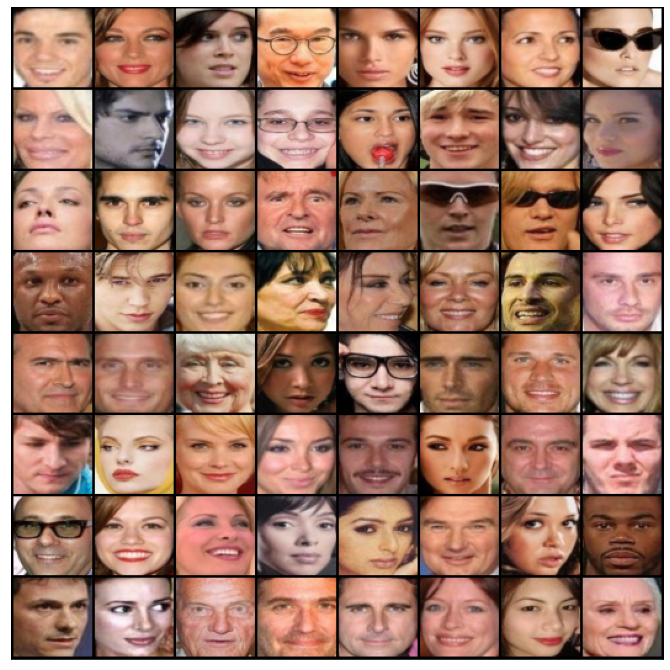

In [22]:
show_batch(train_dl)

## Utilizing GPU

To seamlessly use a GPU, if one is available, I define a couple of helper functions (`get_default_device` & `to_device`) besides a helper class `DeviceDataLoader` to move my model & data to the GPU as required. 

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where this notebook is being run, the default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [24]:
device = get_default_device()
device

device(type='cuda')

I wrap my training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Now I develop the ResNet9 model through extending the `ImageClassificationBase` model besides defining a `conv_block` containing the Convolutional Block as the building block of the aforementioned architecture.

In [27]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64, pool=True)    # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 X 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
model = to_device(Resnet9(3, 2), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

## Model Training

Before starting to train the model, I apply a number of small but important improvements to my fit function:

**Learning Rate Scheduling:** Instead of using a fixed learning rate, I deploy a Learning Rate Scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one I use is called the 
"**One Cycle Learning Rate Policy**", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.


**Weight Decay**: I also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.


**Gradient Clipping**: Aside from the layer weights and outputs, it is also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called Gradient Clipping. 


In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before I begin training, I evaluate the instantiated model in order to see how it performs on the validation set with the initial set of parameters.



In [30]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6913531422615051, 'val_acc': 0.49600884318351746}]

In [31]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [32]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 0.2629, val_loss: 0.1364, val_acc: 0.9531
Epoch [1], last_lr: 0.00935, train_loss: 0.1772, val_loss: 0.1953, val_acc: 0.9244
Epoch [2], last_lr: 0.00972, train_loss: 0.1592, val_loss: 0.1049, val_acc: 0.9639
Epoch [3], last_lr: 0.00812, train_loss: 0.1151, val_loss: 0.1025, val_acc: 0.9672
Epoch [4], last_lr: 0.00556, train_loss: 0.0990, val_loss: 0.0936, val_acc: 0.9656
Epoch [5], last_lr: 0.00283, train_loss: 0.0859, val_loss: 0.0771, val_acc: 0.9700
Epoch [6], last_lr: 0.00077, train_loss: 0.0692, val_loss: 0.0657, val_acc: 0.9773
Epoch [7], last_lr: 0.00000, train_loss: 0.0518, val_loss: 0.0662, val_acc: 0.9765
CPU times: user 59.7 s, sys: 24.7 s, total: 1min 24s
Wall time: 5min 40s


## Model Accuracy and Loss Plots

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

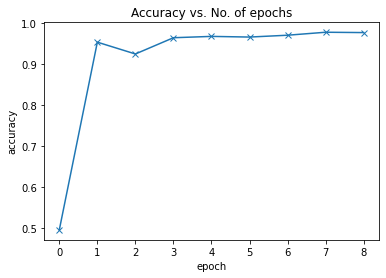

In [34]:
plot_accuracies(history)

**Visualizing traning and validation losses over epochs.**

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

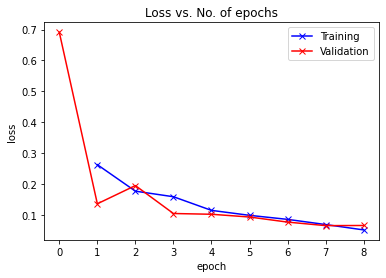

In [36]:
plot_losses(history)

As evident by the above plot, we can see that the model is no suffering from overfitting of data.

In [37]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

 **Visualizing One Cycle Learning Rate Scheduler.**

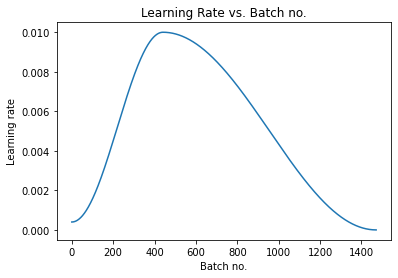

In [38]:
plot_lrs(history)

As anticipated, the `One Cycle Learning Rate Scheduler` starts at a low value, and gradually increases for 30% of the iterations to a defined maximum value of 0.01, followed by gradually decreasing to a very small value.

## Testing with individual Test Datasets images

In [39]:
test_dataset = ImageFolder(val_dir, transform=valid_tfms)

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Label: female , Predicted: female


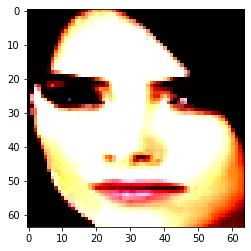

In [41]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: male , Predicted: male


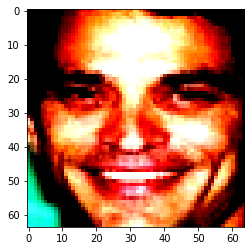

In [42]:
img, label = test_dataset[10000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: female , Predicted: female


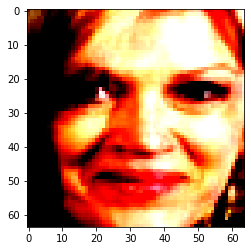

In [43]:
img, label = test_dataset[43]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: female , Predicted: female


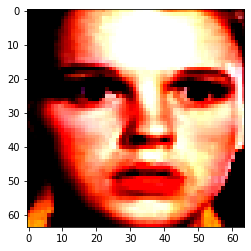

In [44]:
img, label = test_dataset[2098]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: male , Predicted: female


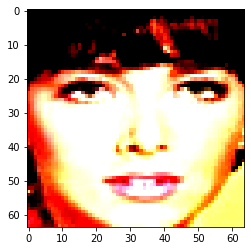

In [45]:
img, label = test_dataset[10876]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))